<a href="https://colab.research.google.com/github/YannisZang/CS_5864/blob/main/HW1/part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 5864: Part 5 Starter code

No GPU is needed or required to complete this assignment.
Complete each **IMPLEMENT ME** section.


## 1) Environment

In [ ]:

import os, random, numpy as np, torch
SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)
device = torch.device("cpu")
print("Using device:", device)


Using device: cpu



## 2) Dataset
Load in the DTD dataset (run this code)

In [ ]:
from pathlib import Path
from typing import List
from torchvision.datasets import DTD

def _get_classes(ds): return list(ds.classes)
def _get_targets(ds):
    if hasattr(ds, "targets"): return list(ds.targets)
    if hasattr(ds, "samples"): return [t for _,t in ds.samples]
    if hasattr(ds, "imgs"):    return [t for _,t in ds.imgs]
    if hasattr(ds, "_labels"): return list(ds._labels)
    return [ds[i][1] for i in range(len(ds))]

def _relpath(ds, i):
    if hasattr(ds, "samples"):
        p,t = ds.samples[i]; return f"{ds.classes[t]}/{Path(p).name}"
    if hasattr(ds, "imgs"):
        p,t = ds.imgs[i];    return f"{ds.classes[t]}/{Path(p).name}"
    if hasattr(ds, "_image_files") and hasattr(ds, "_labels"):
        return f"{ds.classes[ds._labels[i]]}/{Path(ds._image_files[i]).name}"
    img,t = ds[i]
    return f"{ds.classes[t]}/index_{i:05d}.jpg"

train_raw = DTD(root="data", split="train", partition=1, download=True)
test_raw  = DTD(root="data", split="test",  partition=1, download=True)

KEEP = sorted(_get_classes(train_raw))[:8]

def subset_indices(ds):
    T = _get_targets(ds)
    idx = [i for i,y in enumerate(T) if ds.classes[y] in KEEP]
    idx = sorted(idx, key=lambda i: _relpath(ds, i))
    return idx

train_idx = subset_indices(train_raw)
test_idx  = subset_indices(test_raw)

print("Classes (fixed):", KEEP)
print("Train images:", len(train_idx), " Test images:", len(test_idx))


100%|██████████| 625M/625M [00:18<00:00, 33.4MB/s]


Classes (fixed): ['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked']
Train images: 320  Test images: 320


## 3) Image helpers
Convert to grayscale and resize to **224×224** before classical filtering.


In [ ]:
from PIL import Image
def pil_to_grayscale_resized(img: Image.Image, size=224):
    if img.mode != "L": img = img.convert("L")
    img = img.resize((size,size), resample=Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr



## 4) Classical features
Reuse your bank from Part 2.
For each image, convolve with all 48 filters and take the mean absolute response per filter to get a 48-D vector.
Train and apply to test.


In [ ]:
from math import factorial
import numpy as np
import torch, torch.nn.functional as F
import pickle

### IMPLEMENT ME: return your Part-2 filter bank as torch.float32 of shape [48, 1, 49, 49]
def get_filter_bank():
    load_filter = "/content/sample_data/filter_bank.pkl"
    with open(load_filter, "rb") as f:
      filter_bank = pickle.load(f)
    filter_bank = np.array(filter_bank)
    filters = torch.from_numpy(filter_bank).to(torch.float32).unsqueeze(1)
    return filters
    # raise NotImplementedError("Return your [48,1,49,49] filter bank")

### IMPLEMENT ME: compute mean absolute response per filter for ONE grayscale image array (H,W in [0,1])
def mean_abs_response(gray224: np.ndarray, filters: torch.Tensor) -> np.ndarray:
    img = torch.from_numpy(gray224).to(torch.float32).unsqueeze(0).unsqueeze(0) # [batch, channel, H, w]
    # padding = filters.shape[-1] // 2
    # img_padded = F.pad(img, (padding, padding, padding, padding), mode="constant")
    response = F.conv2d(img, filters) #[1, 48, H, w]
    mean_abs = response.abs().mean(dim=(0,2,3))  # [48]
    return mean_abs.numpy()
    #raise NotImplementedError

### IMPLEMENT ME: loop over indices to build X_train (N×48) and X_test (M×48)
def extract_classical_features(ds, indices, filters: torch.Tensor) -> np.ndarray:
    x_set = []
    for i in indices:
      pil_img, label = ds[i]
      gray_img = pil_to_grayscale_resized(pil_img, size=224)
      features = mean_abs_response(gray_img, filters)
      x_set.append(features)
    return np.stack(x_set)

    # raise NotImplementedError

# Example usage
fb = get_filter_bank()
Xtr_classical = extract_classical_features(train_raw, train_idx, fb)
Xte_classical = extract_classical_features(test_raw,  test_idx,  fb)
print("Classical features:", Xtr_classical.shape, Xte_classical.shape)


Classical features: (320, 48) (320, 48)


## 5) CNN features (512-D)
Use ResNet-18 (ImageNet-1k weights) with the official transforms attached to the weights.
Extract the 512-D vector after global average pooling layer at the end

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms


### IMPLEMENT ME: build (a) pretrained resnet18 model, (b) feature extractor up to avgpool, (c) official preprocess transforms
def build_resnet18_and_transforms():
  # pretrain resnet18
  weights = ResNet18_Weights.DEFAULT
  model = models.resnet18().eval()

  # keep up to avgpool, dispose fc leyer
  # [Conv1, BN1, ReLU, MaxPool, Layer1, Layer2, Layer3, Layer4, AvgPool, Fc]
  feature_extractor = nn.Sequential(*list(model.children())[:-1])
  feature_extractor.eval()

  # official preprocess transforms
  preprocess = weights.transforms()

  return model, feature_extractor, preprocess

  #raise NotImplementedError

### IMPLEMENT ME: loop over indices, preprocess each image, run feature extractor, and flatten to 512-D vectors
def extract_penultimate_features(ds, indices, feature_extractor, preprocess) -> np.ndarray:
  x_set = []
  with torch.no_grad():
    for i in indices:
      img, _ = ds[i]
      # gray_img = pil_to_grayscale_resized(img, size=224)
      x = preprocess(img).unsqueeze(0) # [1, 3, 224, 224]
      features = feature_extractor(x) # [1, 512, 1, 1]
      features = features.view(features.size(0), -1) # [1, 512]
      x_set.append(features.numpy())
  return np.vstack(x_set)
    ## raise NotImplementedError

## Example usage
model, feat_extractor, preprocess = build_resnet18_and_transforms()
Xtr_pen = extract_penultimate_features(train_raw, train_idx, feat_extractor, preprocess)
Xte_pen  = extract_penultimate_features(test_raw,  test_idx,  feat_extractor, preprocess)
print("Penultimate features:", Xtr_pen.shape, Xte_pen.shape)


Penultimate features: (320, 512) (320, 512)



## 6) CNN features (conv1)

Here you'll treat conv1 (the first conv layer) as a learned filter bank.
Compute mean absolute activation per conv1 channel (pre-BN) to get a 64-D vector.

In [ ]:
### IMPLEMENT ME: extract mean-|activation| per conv1 channel (pre-BN) for each image

def extract_conv1_summary(ds, indices, model, preprocess) -> np.ndarray:
    # HINT: To do this one you should register a forward hook on model.conv1 OR run model.conv1 directly.
  model.eval()

  act = []

  def hook(module, input, output):
    act.append(output.detach())

  handle = model.conv1.register_forward_hook(hook)

  x_set = []

  with torch.no_grad():
    for i in indices:
      img, _ = ds[i]
      x = preprocess(img).unsqueeze(0)

      forward = model(x)

      a = act.pop() # [1,64,H,W]

      summary = a.abs().mean(dim=(0,2,3))

      x_set.append(summary.numpy())

  handle.remove()

  return np.vstack(x_set)
  ## raise NotImplementedError

Xtr_c1 = extract_conv1_summary(train_raw, train_idx, model, preprocess)
Xte_c1  = extract_conv1_summary(test_raw,  test_idx,  model, preprocess)
print("Conv1 summary:", Xtr_c1.shape, Xte_c1.shape)

Conv1 summary: (320, 64) (320, 64)


## 7) Linear classifier
Use multinomial logistic regression with: `lbfgs`, `C=1.0`, `max_iter=500`, `multi_class='multinomial'`, `random_state=2025`.
Report top-1 accuracy, confusion matrix, macro precision/recall for each representation.


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

### IMPLEMENT ME: return y (targets) for given indices
def get_targets(ds, indices) -> np.ndarray:
  return np.array([ds[i][1] for i in indices])
  # raise NotImplementedError

### IMPLEMENT ME: standardize train/test, fit LR, print metrics, return trained model & scaler
def train_and_evaluate(Xtr, ytr, Xte, yte, tag=""):
  # HINTS:
  scaler = StandardScaler()
  Xtr_s = scaler.fit_transform(Xtr)
  Xte_s = scaler.transform(Xte)
  clf = LogisticRegression(
      solver="lbfgs",
      C=1.0,
      max_iter=500,
      multi_class='multinomial',
      random_state=2025
  )
  clf.fit(Xtr_s, ytr)
  yhat = clf.predict(Xte_s)
  # print accuracy, confusion matrix, classification report (digits=2)
  print(f"{tag}")
  print("Accuracy:", accuracy_score(yte, yhat))
  print("Classification Report:", classification_report(yte, yhat, digits=2))
  print("Confusion Matrix:", confusion_matrix(yte, yhat))
  # raise NotImplementedError

# Example (after you computed feature matrices):
ytr = get_targets(train_raw, train_idx)
yte = get_targets(test_raw,  test_idx)
train_and_evaluate(Xtr_classical, ytr, Xte_classical, yte, tag="Classical 48D")
train_and_evaluate(Xtr_pen,       ytr, Xte_pen,       yte, tag="CNN penultimate 512D")
train_and_evaluate(Xtr_c1,        ytr, Xte_c1,        yte, tag="CNN conv1 summary 64D")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classical 48D
Accuracy: 0.5125
Classification Report:               precision    recall  f1-score   support

           0       0.88      0.72      0.79        40
           1       0.31      0.45      0.36        40
           2       0.42      0.35      0.38        40
           3       0.45      0.55      0.49        40
           4       0.25      0.25      0.25        40
           5       0.79      0.75      0.77        40
           6       0.55      0.53      0.54        40
           7       0.67      0.50      0.57        40

    accuracy                           0.51       320
   macro avg       0.54      0.51      0.52       320
weighted avg       0.54      0.51      0.52       320

Confusion Matrix: [[29  3  1  0  0  6  0  1]
 [ 0 18  1  8 10  1  2  0]
 [ 0  4 14  6 11  0  3  2]
 [ 0  8  0 22  7  0  1  2]
 [ 0  8  9  7 10  0  5  1]
 [ 2  3  3  0  0 30  2  0]
 [ 2  7  3  1  2  0 21  4]
 [ 0  8  2  5  0  1  4 20]]
CNN penultimate 512D
Accuracy: 0.303125
Classification Repor

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



## 8) Visualizations

### 8a) Conv1 kernels (montage)
Show all 64 conv1 kernels as patches (min–max normalize per kernel across channels).


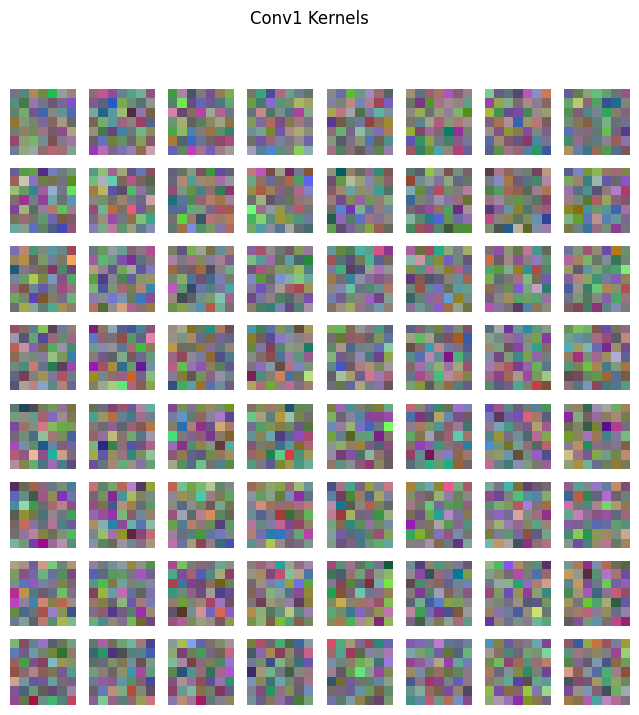

In [ ]:
### IMPLEMENT ME: conv1 color montage
import matplotlib.pyplot as plt

def conv1_color_montage(model):
    # HINT: model.conv1.weight has shape [64,3,7,7]; transpose for imshow !
    weights = model.conv1.weight.data.clone()
    w_min, w_max = weights.min(), weights.max()
    weights = (weights - w_min) / (w_max - w_min)

    weights = weights.numpy()

    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        # [3,7,7] → [7,7,3]
        w = np.transpose(weights[i], (1, 2, 0))
        ax.imshow(w)
        ax.axis("off")

    plt.suptitle("Conv1 Kernels", fontsize=12)
    plt.show()

    # raise NotImplementedError

conv1_color_montage(model)



### 8b) Activation maps on 3 exemplars
Choose the first lexicographic image from classes `KEEP[0]`, `KEEP[3]`, `KEEP[7]`.
For each image, show input, 6 conv1 activation maps with largest mean activation, 4 classical responses (0°, 90°, one second-derivative “bar”, one LoG “spot”). Add brief captions to distinguish them.

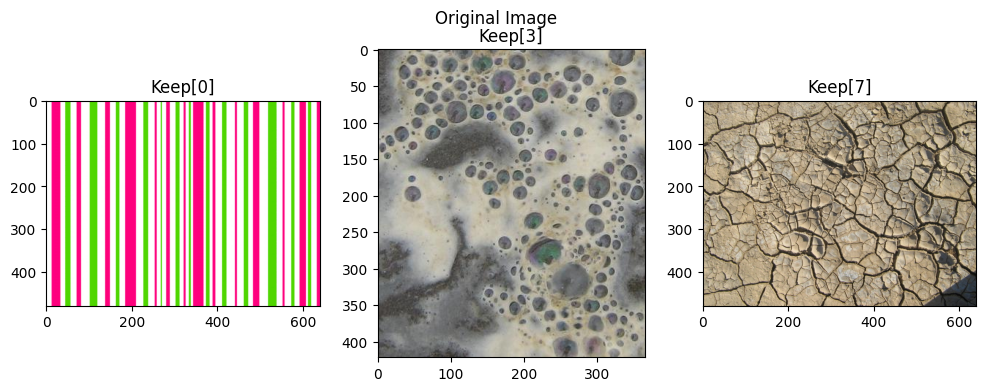

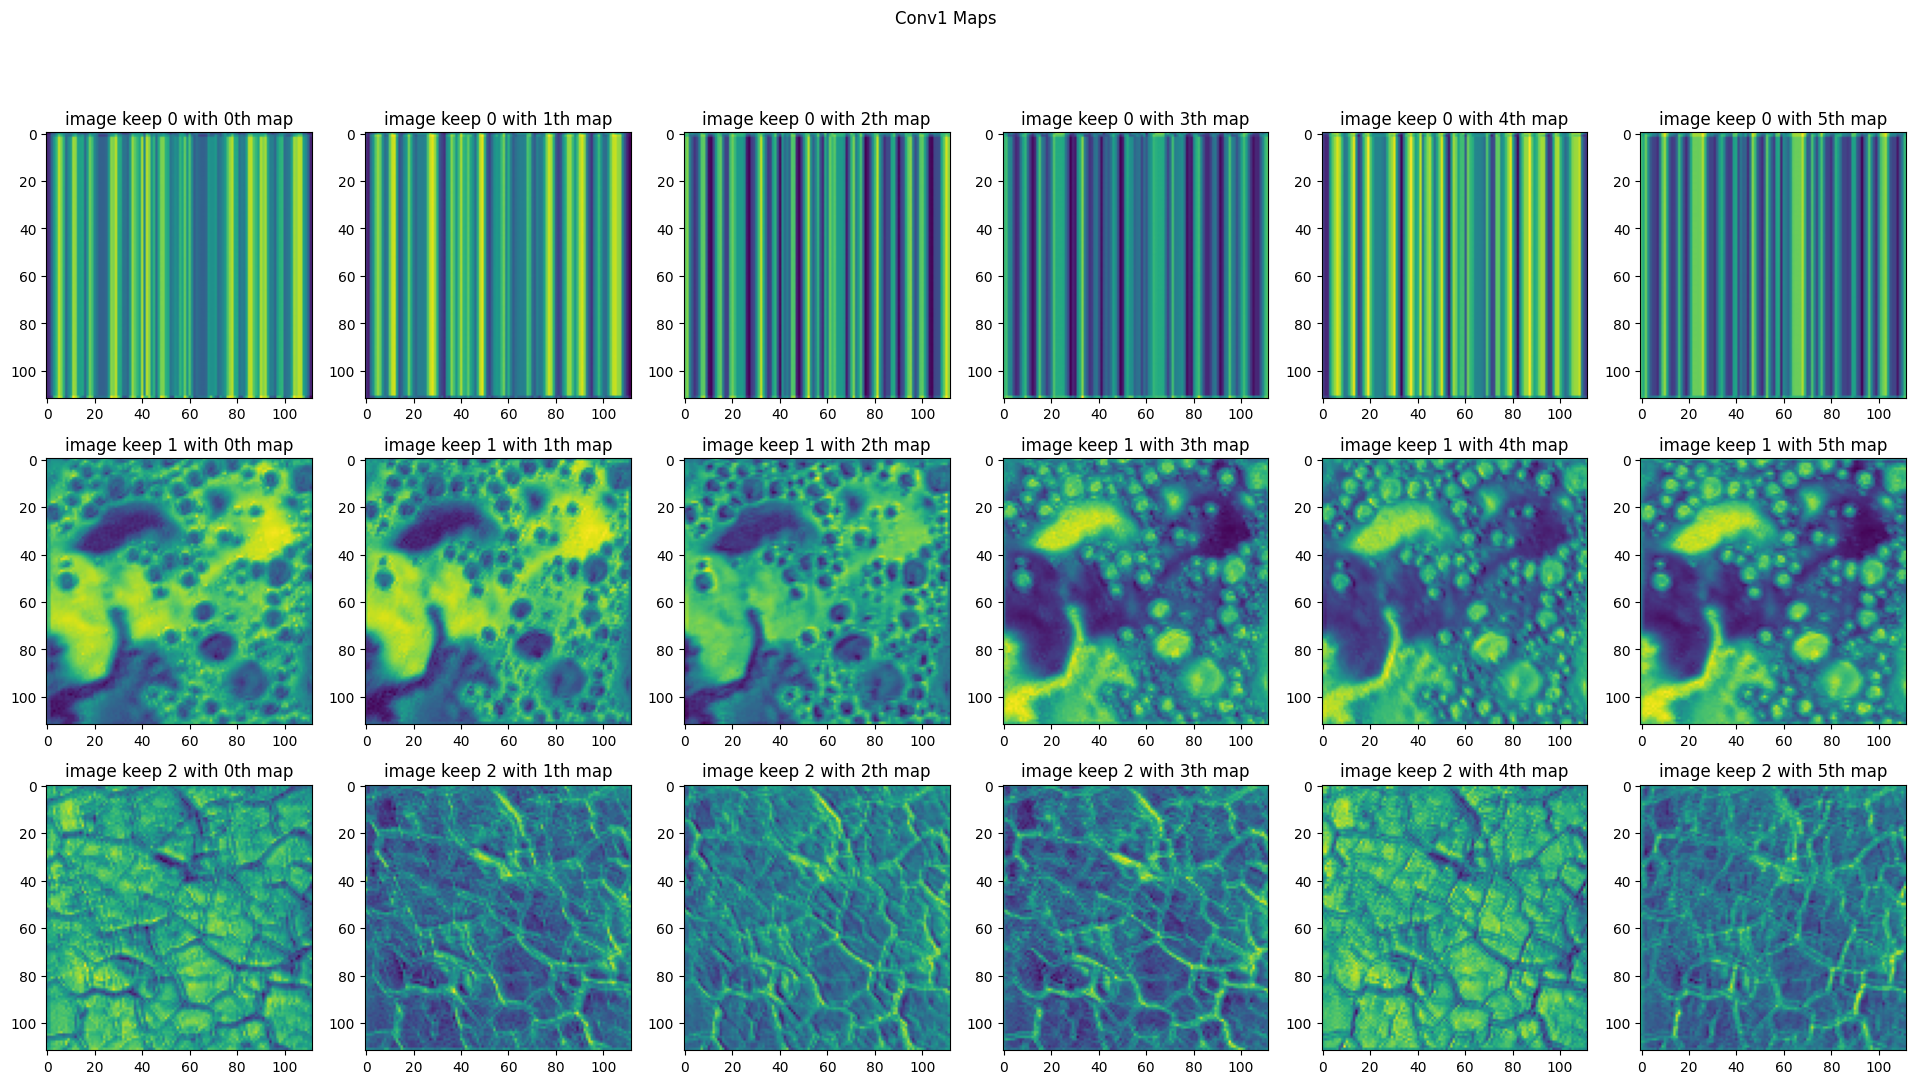

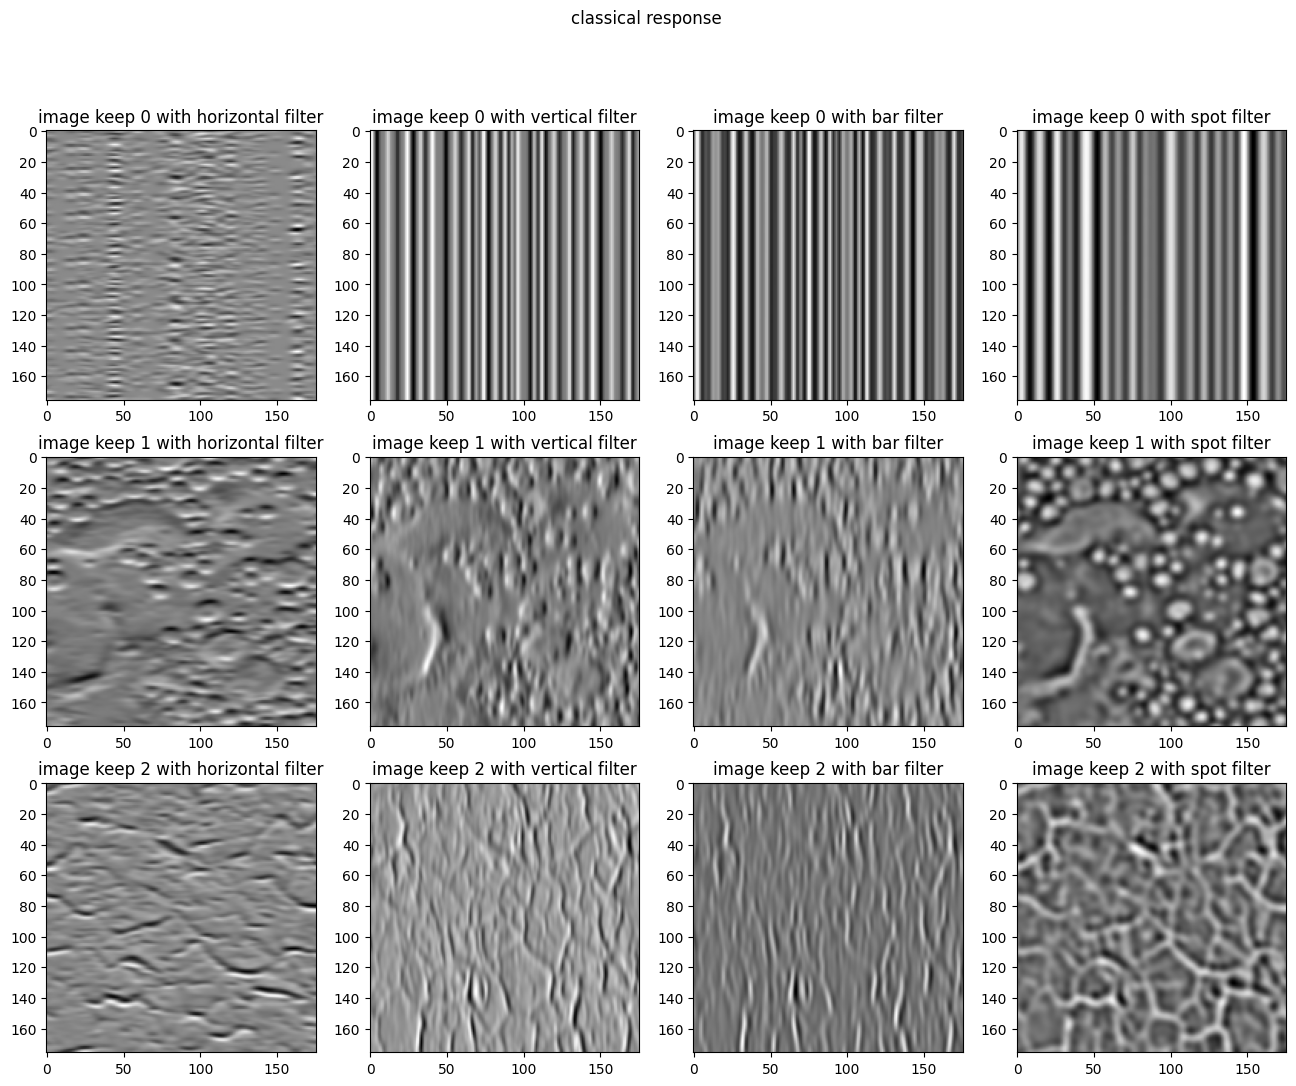

In [ ]:
### IMPLEMENT ME: top-k conv1 activation maps and classical responses for selected images

def show_activation_maps_and_classical_responses(model, preprocess, fb):
  # pick 3 images idx
  class_name = [KEEP[0], KEEP[3], KEEP[7]]

  imgs = []
  conv1_act = []

  for cln in class_name:
    class_id = train_raw.classes.index(cln)
    idx = [i for i in train_idx if train_raw[i][1] == class_id]
    imgs.append(train_raw[idx[0]][0])

  # plt input
  fig, ax = plt.subplots(1, 3, figsize=(12, 4))
  ax[0].imshow(imgs[0])
  ax[0].set_title("Keep[0]")
  ax[1].imshow(imgs[1])
  ax[1].set_title("Keep[3]")
  ax[2].imshow(imgs[2])
  ax[2].set_title("Keep[7]")
  plt.suptitle("Original Image")
  plt.show()

  # 6 conv1 activation maps with largest mean activation
  conv1_act = []
  for img in imgs:
    x = preprocess(img).unsqueeze(0) # [1,3,224,224]
    with torch.no_grad():
      act = model.conv1(x).squeeze(0) # [64,H,W]
    mean_act = act.abs().mean(dim=(1, 2)) # [64]
    top_k_idx = torch.topk(mean_act, 6).indices
    conv1_act.append(act[top_k_idx].numpy()) # 6 top maps for one img

  # plt conv top 6
  fig, axes = plt.subplots(3, 6, figsize=(24, 12))

  for i in range(3):
    for j in range(6):
      axes[i][j].imshow(conv1_act[i][j])
      axes[i][j].set_title(f"image keep {i} with {j}th map")
  plt.suptitle("Conv1 Maps")
  plt.show()


  # 4 classical responses (0°, 90°, one second-derivative “bar”, one LoG “spot”
  c_response = []

  horizontal_filter = fb[3].unsqueeze(0)
  vertical_filter = fb[0].unsqueeze(0)
  bar_filter = fb[24].unsqueeze(0)
  spot_filter = fb[37].unsqueeze(0)

  for img in imgs:
    gray_img = pil_to_grayscale_resized(img, 224)
    img_t = torch.from_numpy(gray_img).float().unsqueeze(0).unsqueeze(0)
    response_h = F.conv2d(img_t, horizontal_filter).squeeze().numpy()
    response_v = F.conv2d(img_t, vertical_filter).squeeze().numpy()
    response_b = F.conv2d(img_t, bar_filter).squeeze().numpy()
    response_s = F.conv2d(img_t, spot_filter).squeeze().numpy()
    c_response.append([response_h, response_v, response_b, response_s])


  fig, axes = plt.subplots(3, 4, figsize=(16, 12))

  for i in range(3):
    axes[i][0].imshow(c_response[i][0], cmap="gray")
    axes[i][0].set_title(f"image keep {i} with horizontal filter")
    axes[i][1].imshow(c_response[i][1], cmap="gray")
    axes[i][1].set_title(f"image keep {i} with vertical filter")
    axes[i][2].imshow(c_response[i][2], cmap="gray")
    axes[i][2].set_title(f"image keep {i} with bar filter")
    axes[i][3].imshow(c_response[i][3], cmap="gray")
    axes[i][3].set_title(f"image keep {i} with spot filter")
  plt.suptitle("classical response")
  plt.show()

  # raise NotImplementedError
show_activation_maps_and_classical_responses(model, preprocess, fb)


In 5–10 sentences explain which representation performed best and why. Compare the 48-D classical summary, the 64-D conv1 summary, and the 512-D features. Do the conv1 visualizations you made support your explanation?

Answer:
From the classification metrics and report, I found that the classical features provides the best performance on the datasets classification prediction. 48D features performs well on some of the classes, such as class 0, class 5 and class 7, which means that edge, spot and bar detectors are suited to texture recongnition. The classical filter bank inlcude filters that mainly detect edges, lines and spots. It is better to represent textures. The conv1 weights trained from more diversified datasets that may capture more complicated shapes rather than general textures. The visulation of conv1 kernals proves that they capture unregular features.